# Topic Modeling using Theses' Abstracts
## 4. Data Preprocessing
Mai Vu<br>
Helsinki Metropolia University of Applied Sciences<br>
Bachelor’s Thesis<br>
May 2021

In [1]:
#Basic libraries
import random
import re
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from langdetect import detect
from langdetect import detect_langs
from collections import defaultdict
from collections import Counter
from wordcloud import WordCloud
from itertools import chain

#Libraries for data visualization
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected = True)
init_notebook_mode(connected = True)

#Libraries for NLP
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

### 4.1 Data Exploration

In [2]:
#Read data from pickle file
infile = open(r'final_data','rb')
df = pickle.load(infile)
infile.close()
df.reset_index()
print('Data length:', len(df))

#Count length of English and Finnish abstracts
df['en_fi_length'] = df['en'].str.split().str.len() + df['fi'].str.split().str.len()

df.sample(5)

Data length: 174955


,handle,year,original_language,organization,google_translated_en,en,google_translated_fi,fi,en_fi_length
13546,10024/15429,2010,fi,Diaconia University of Applied Sciences,0,"Salmela, Jenni. Online Peer Support for People...",0,"Salmela, Jenni. Virtuaalista vertaistukea unih...",671
25918,10024/29917,2011,fi,Satakunta University of Applied Sciences,0,The purpose of this thesis was to survey the i...,0,Tämän opinnäytetyön tarkoituksena oli kartoitt...,532
30321,10024/51387,2012,en,Savonia University of Applied Sciences,0,Abstract Kosovo is a country that has been ind...,0,Tiivistelmä Kosovo itsenäistyi 17.2.2008 ja s...,553
41207,10024/40288,2012,fi,Häme University of Applied Sciences,1,The purpose of this thesis was to find out the...,0,Tämän opinnäytetyön tarkoituksena oli selvittä...,432
124822,10024/151591,2018,fi,Satakunta University of Applied Sciences,0,The purpose of this thesis was to study the na...,0,Opinnäytetyössä selvitettiin suomalaisyrityste...,576


In [3]:
df.isna().sum()

handle                  0
year                    0
original_language       7
organization            3
google_translated_en    0
en                      0
google_translated_fi    0
fi                      0
en_fi_length            0
dtype: int64

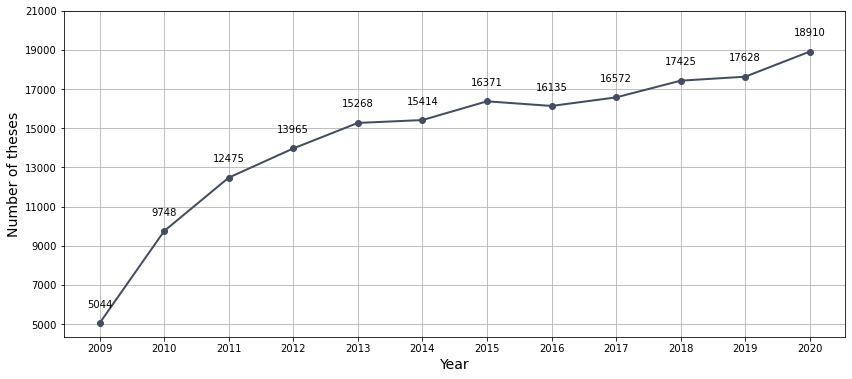

In [4]:
plt.figure(figsize = (14, 6))
plt.plot(df.groupby('year').size(), '-o', color = '#434c60', linewidth = 2)
plt.xticks(np.arange(2009, 2021))
plt.yticks(np.arange(5000, 22000, 2000))
plt.ylabel('Number of theses', size = 14)
plt.xlabel('Year', size = 14)
plt.grid()
for x, y in zip(np.arange(2009, 2021), df.groupby('year').size()):
    plt.annotate(y, (x,y),
                 textcoords = "offset points",
                 xytext = (0, 16), 
                 ha = 'center')
plt.savefig('NumberOfThesesPlot.png')
plt.show()

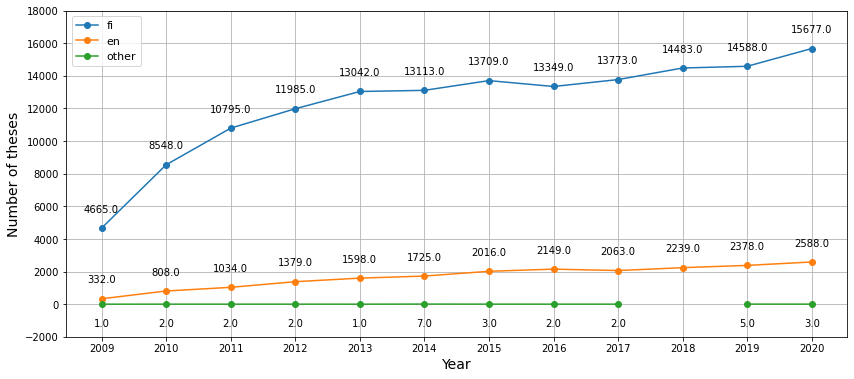

In [5]:
# plot data
plt.figure(figsize = (14, 6))
plt.plot(df.groupby(['year', 'original_language']).size().unstack()['fi'], '-o',
         df.groupby(['year', 'original_language']).size().unstack()['en'], '-o',
         df.groupby(['year', 'original_language']).size().unstack()['other'], '-o')
plt.grid()
for x, y in zip(np.arange(2009, 2021), df.groupby(['year', 'original_language']).size().unstack()['en']):
    plt.annotate(y, (x,y),
                 textcoords = "offset points",
                 xytext = (0, 16), # distance from text to points (x,y)
                 ha = 'center') # horizontal alignment can be left, right or center
for x, y in zip(np.arange(2009, 2021), df.groupby(['year', 'original_language']).size().unstack()['fi']):
    plt.annotate(y, (x,y),
                 textcoords = "offset points",
                 xytext = (0, 16), # distance from text to points (x,y)
                 ha = 'center') # horizontal alignment can be left, right or center
for x, y in zip(np.arange(2009, 2021), df.groupby(['year', 'original_language']).size().unstack()['other']):
    plt.annotate(y, (x,y),
                 textcoords = "offset points",
                 xytext = (0, -22), # distance from text to points (x,y)
                 ha = 'center') # horizontal alignment can be left, right or center
plt.ylabel('Number of theses', size = 14)
plt.xlabel('Year', size = 14)
plt.xticks(np.arange(2009, 2021))
plt.yticks(np.arange(-2000, 20000, 2000))
plt.legend(['fi', 'en', 'other'], fontsize = 11)
plt.savefig('NumberOfThesesPlot_3Lang.png')
plt.show()

In [6]:
fig = go.Figure(data = [go.Pie(labels = list(Counter(df['original_language']).keys()), 
                               values = list(Counter(df['original_language']).values()),
                               textinfo = 'label + percent', titleposition = "bottom center")])
fig.show()

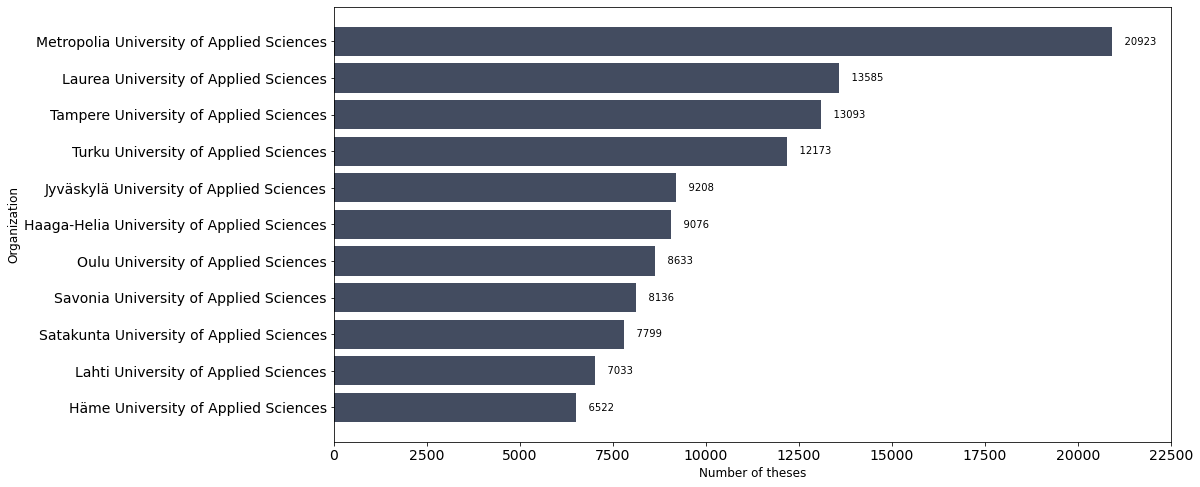

In [7]:
plt.figure(figsize = (15, 8))

x = [key for key, value in Counter(df['organization']).most_common(11)]
y = [value for key, value in Counter(df['organization']).most_common(11)]
x.reverse()
y.reverse()

plt.barh(x, y, color = '#434c60')
for i, v in enumerate(y):
    plt.text(v, i, "    " + str(v), color = 'k', va = 'center')
plt.ylabel('Organization', fontsize = 12)
plt.xlabel('Number of theses', fontsize = 12)
plt.xticks(np.arange(0, 24000, 2500), fontsize = 14)
plt.yticks(fontsize = 14)
plt.savefig('OrganizationBarPlot.png')
plt.show()

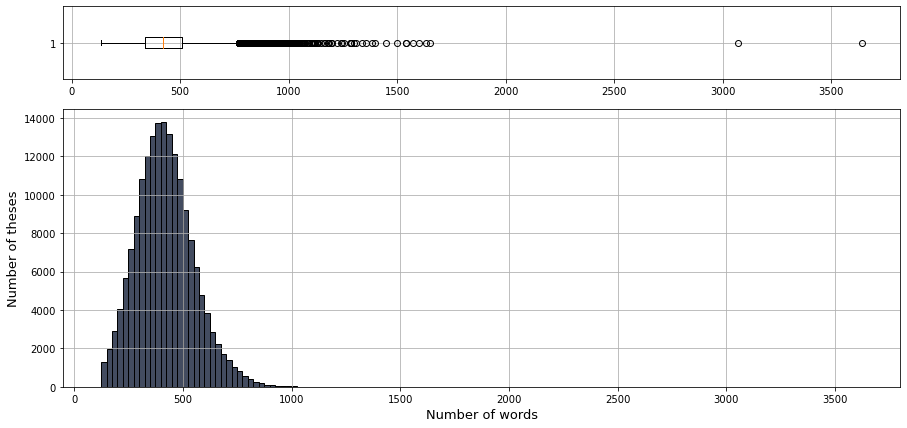

In [8]:
fig = plt.figure(figsize = (15, 7))  
ax1 = plt.subplot2grid(shape = (15,10), loc = (0, 0), colspan = 15, rowspan = 3)
ax2 = plt.subplot2grid(shape = (15, 10), loc = (4, 0), colspan = 15, rowspan = 12)
ax1.boxplot(df['en_fi_length'], vert = False)
ax2.hist(df['en_fi_length'], bins = range(int(np.amin(df['en_fi_length'])), int(np.amax(df['en_fi_length'])), 25), color = '#434c60', edgecolor = 'k', align = 'left')
ax2.set_ylabel('Number of theses', fontsize = 13)
plt.xlabel('Number of words', fontsize = 13)
ax1.grid()
ax2.grid()
plt.savefig('Box&HistPlot.png')
plt.show()

### 4.2 Text Preparation and Word Clouds

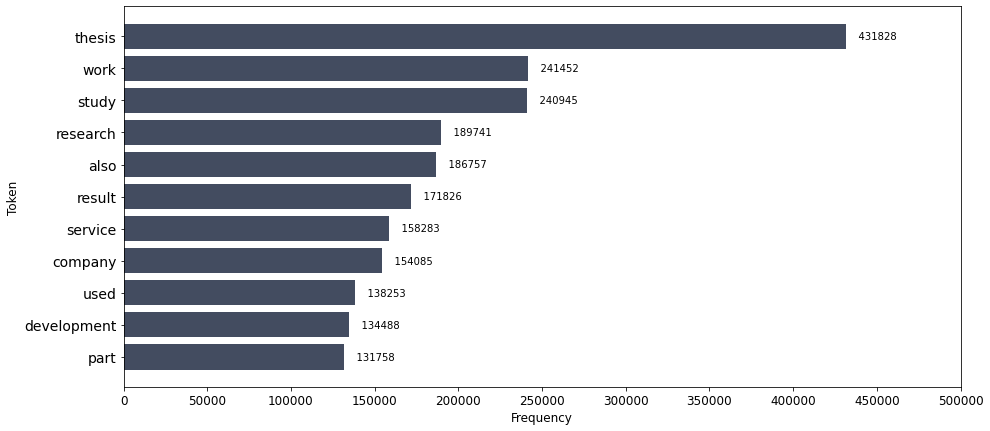

In [9]:
#MERGE ALL ABSTRACTS AND CREATE STOPWRODS DICTIONARY
text = ''
text = " ".join(abstract.lower() for abstract in df['en'])
eng_stopwords = set(stopwords.words('english'))

#LEMMATIZATION
lemmatizer = WordNetLemmatizer()
tokens = nltk.word_tokenize(text) #Tokenizing
tokens = [token for token in tokens if token.isalpha() and token not in eng_stopwords] #Delete punctuation and stopwords
tokens = [lemmatizer.lemmatize(token) for token in tokens] #Using lemmatizer from NLTK library
text = ' '.join([token for token in tokens]) #Put words back in text

#Count words
counter = Counter()
counter.update(tokens)

#Plot
plt.figure(figsize = (15, 7))
x = [key for key, value in counter.most_common(11)]
y = [value for key, value in counter.most_common(11)]
x.reverse()
y.reverse()
plt.barh(x, y, color = '#434c60')
for i, v in enumerate(y):
    plt.text(v, i, "    " + str(v), color = 'k', va = 'center')
plt.ylabel('Token', fontsize = 12)
plt.xlabel('Frequency', fontsize = 12)
plt.xticks(np.arange(0, 550000, 50000), fontsize = 12)
plt.yticks(fontsize = 14)
plt.savefig('WordsFrequency.png')
plt.show()

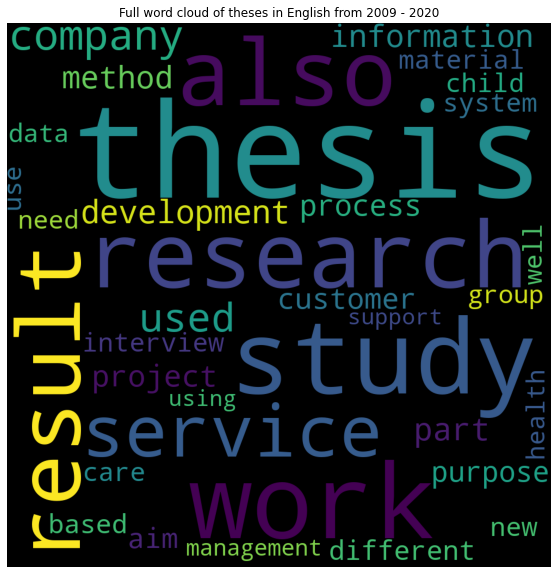

In [10]:
#Word cloud of theses in English from 2009 - 2020 | FULL
wordcloud = WordCloud(width = 1000, height = 1000, 
                      max_words = 35, collocations = False, 
                      normalize_plurals = False, stopwords = "").generate(text)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.title('Full word cloud of theses in English from 2009 - 2020')
plt.axis("off")
#plt.savefig('WordCloud1.png')
plt.show()